alpha: 0.07690431050059794 rho: 0.1836117623841108 nu: 1.4098072886417798


Text(0.6, 0.9, '$\\alpha=$0.076904\n$\\beta=$0.5\n$\\rho=$0.183612\n$\\nu=$1.409807')

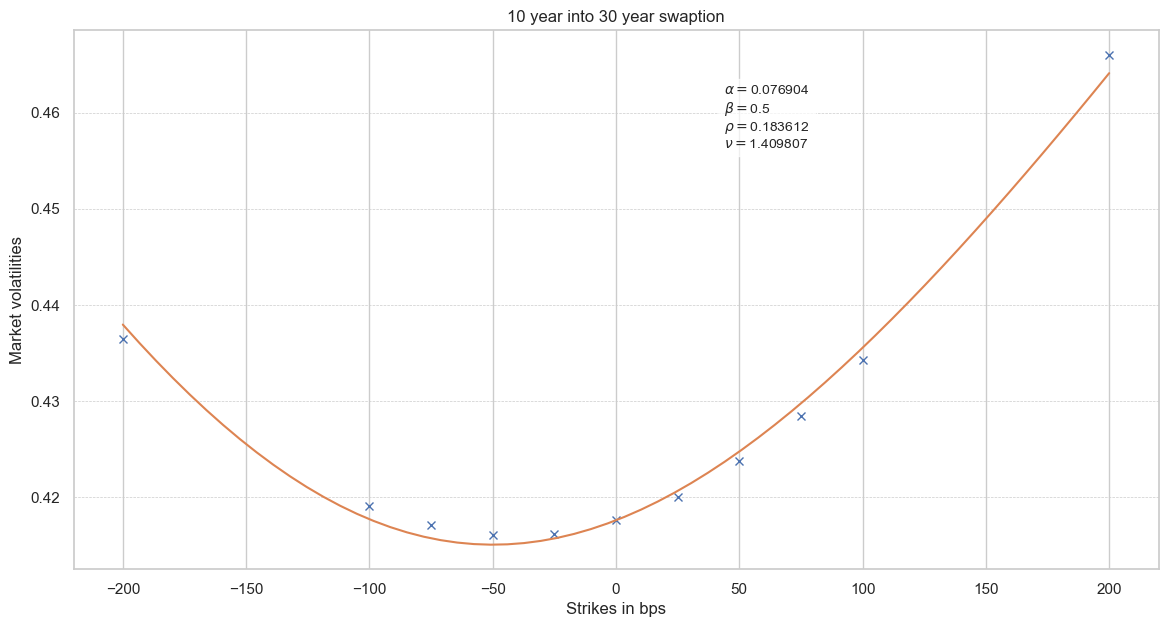

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho):
    '''Given a list of strike prices and SABR parameters, returns what the SABR
    model predicts the market volatility to be. Calculated from equations (2.17) 
    and (2.18) in Hagan, Patrick S., Deep Kumar, Andrew S. Lesniewski, and 
    Diana E. Woodward "Managing smile risk." The Best of Wilmott 1 (2002): 249-296.
    '''
    output = np.zeros(len(K))
    
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
            part_1 = (1.0 - beta)**2.0*alpha**2.0/(24.0*f**(2.0 - 2.0*beta))
            part_2 = rho*beta*alpha*nu/(4.0*f**(1.0 - beta))
            part_3 = (2.0 - 3.0*rho**2)*nu**2.0/24.0
            
            output[i] = (alpha/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
            logfK = np.log(f/K[i])
            fkbpow = (f*K[i])**((1.0 - beta)/2.0)
            z = nu*fkbpow*logfK/alpha
            xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
            part_1 = ((1.0-beta)**2.0)*(alpha**2.0)/(24.0*fkbpow**2.0)
            part_2 = (rho*beta*nu*alpha)/(4.0*fkbpow)
            part_3 = (2.0-3.0*rho**2)*nu**2.0/24.0
            part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
            part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
            output[i] = (alpha*z*(1 + (part_1 + part_2 + part_3)*t_exp ))/(fkbpow*xz*(1 + part_4 + part_5 ))
            
    return output

def atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho):
    '''Returns alpha given the forward price, the at-the-money volatility, the 
    time to exirpy (t_exp) and the other parameters in the SABR model by 
    solving a cubic equation for alpha, equation (2.18) in Hagan, Patrick S., 
    Deep Kumar, Andrew S. Lesniewski, and Diana E. Woodward. 
    "Managing smile risk." The Best of Wilmott 1 (2002): 249-296. 
    '''
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*nu**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*nu*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min() 

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    ''' Returns the parameters alpha, nu and rho given a parameter beta, 
    forward price, a list of market volatilities and corrsponding strike 
    spread. Instead of doing a regression in all three parameters, this method 
    calculates alpha when needed from nu and rho. Hence a regression is done 
    in only two variables.
    '''
    def func_to_optimize(K,nu,rho):
        alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
        return  SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)
     
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    nu = popt[0]
    rho = popt[1]
    alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
    
    return [alpha, nu, rho]
        


#10Y30Y 2024
beta = 0.5
sigmas = np.array([0.4364, 0.4191, 0.41706,0.41605, 0.41619,0.41757,0.42003,0.42370,0.42847,0.43428,0.46603])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 30
atm_sigma = 0.41757
f = 0.23401
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)
textbox = "\n".join((r"$\alpha=$"+f"{round(alpha,6)}",r"$\beta=$"+f"{beta}",
                        r"$\rho=$"+f"{round(rho,6)}", r"$\nu=$"+f"{round(nu,6)}"))
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas, 'x')
plt.plot(Ks_in_bps,vols_from_Ks)
plt.xlabel("Strikes in bps")
plt.ylabel("Market volatilities")
plt.title(f"{t_exp} year into {tenor} year swaption")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.text(0.6, 0.9, textbox, transform=ax.transAxes, fontsize=10,
    verticalalignment='top',bbox=dict(facecolor='white', alpha=0.7))

alpha: 0.07980335280568916 rho: 0.20417036723169854 nu: 1.4649390675883547


Text(0.6, 0.9, '$\\alpha=$0.079803\n$\\beta=$0.5\n$\\rho=$0.20417\n$\\nu=$1.464939')

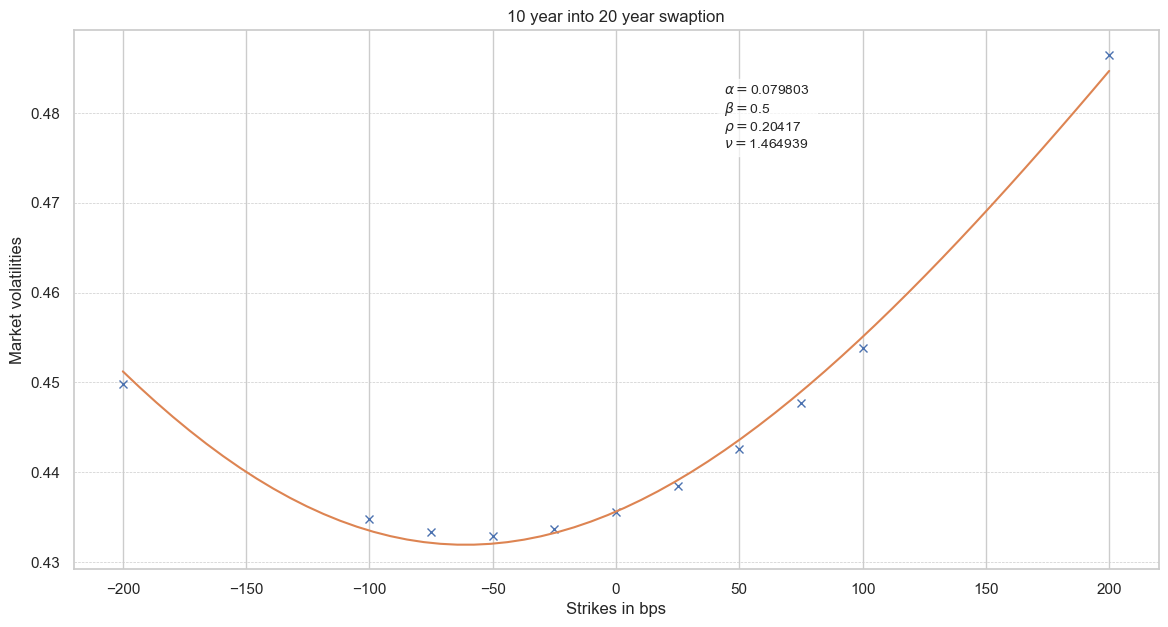

In [49]:
#10Y20Y 2024
beta = 0.5
sigmas1 = np.array([0.44983,	0.43478,	0.43329,	0.43288,	0.43360,
                   	0.43559,	0.43846,	0.44256,	0.44772,	0.45385,	0.48650])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 20
atm_sigma = 0.43559
f = 0.251744
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas1, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)
textbox = "\n".join((r"$\alpha=$"+f"{round(alpha,6)}",r"$\beta=$"+f"{beta}",
                        r"$\rho=$"+f"{round(rho,6)}", r"$\nu=$"+f"{round(nu,6)}"))
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas1, 'x')
plt.plot(Ks_in_bps,vols_from_Ks)
plt.xlabel("Strikes in bps")
plt.ylabel("Market volatilities")
plt.title(f"{t_exp} year into {tenor} year swaption")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.text(0.6, 0.9, textbox, transform=ax.transAxes, fontsize=10,
    verticalalignment='top',bbox=dict(facecolor='white', alpha=0.7))